# Main goal: 
Here, we aim to integrate differential analysis results (treated vs. non-treated) toward making a final list of genes which are significantly methylated, expressed and stabilized.

=> table of these genes with all logFCs, pvalues and screening scores.

In [2]:
ls 

combined_analysis/                            img/           README.md
combined_analysis-intersectional-genes.ipynb  LICENSE        Ribo-seq/
combined_analysis-intersectional-genes.md     m6A-genes.tsv  RNA-seq/
combined_analysis-m6A-signals.ipynb           meRIP-seq/     util.py
CRISPRi-screen/                               __pycache__/


In [1]:
import pandas as pd 
import numpy as np
from matplotlib.pyplot import subplots
from itertools import chain, product
from venn import venn 

from util import *

# Intersectional genes 
Find top genes across all cell lines and high throughput experiments:

- $\Delta$RNA expression 
- $\Delta$RNA stability 
- $\Delta$RNA methylation  
- $\Delta$Phenotype (CRISPR Screen Rho score)
- $\Delta$Translational efficiency

In [ ]:
data = load_data(comparisons=True)

In [ ]:
ls 

In [19]:
data.keys()#['hl60']

dict_keys(['hl60', 'kg1', 'molm14', 'ociaml2', 'ociaml3', 'thp1'])

In [20]:
Top = {}

Top['TE']   = set_Top_TE  (0,0.05,data)
Top['Mtyl'] = set_Top_Mtyl(0,0.05,data)
# Top['Rho']  = set_Top_Rho (0,0.05,data)
Top['Exp']  = set_Top_Exp (0,0.05, 2,data)
Top['Stbl'] = set_Top_Stbl(0,0.05, 2,data)


Subset Top TE data frame:
up:  40
down: 11
(te_thr=0, fdr_thr=0.05)
Subset Top Mtyl data frame:
up:  2042
down: 1632
(fc_thr=0, pv_thr=0.05)
Subset Top Exp data frame:
up:  2910
down: 2494
(fc_thr=0, pv_thr=0.05) in more than 2 cell lines
Subset Top Stbl data frame:
up:  388
down: 374
(fc_thr=0, pv_thr=0.05) in more than 2 cell lines


### Intersection of all genes across different datasets

- https://pypi.org/project/venn/

Select top gene names 

In [21]:
Exp_up = Top['Exp']['up'].gene_name.tolist()
Stbl_up = Top['Stbl']['up'].gene_name.tolist()
TE_up = Top['TE']['up'].gene_name.tolist()
# Rho_up = Top['Rho']['up'].gene_name.tolist()
Hyper_m6A = Top['Mtyl']['up'].gene_name.tolist()

Exp_down = Top['Exp']['down'].gene_name.tolist()
Stbl_down = Top['Stbl']['down'].gene_name.tolist()
TE_down = Top['TE']['down'].gene_name.tolist()
# Rho_down = Top['Rho']['down'].gene_name.tolist()
Hypo_m6A = Top['Mtyl']['down'].gene_name.tolist()

NameError: name 'Rho_up' is not defined

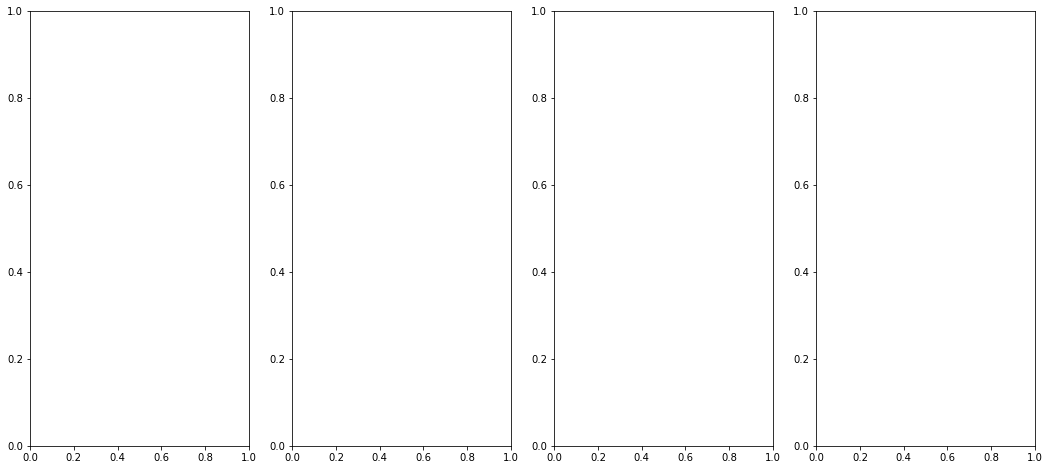

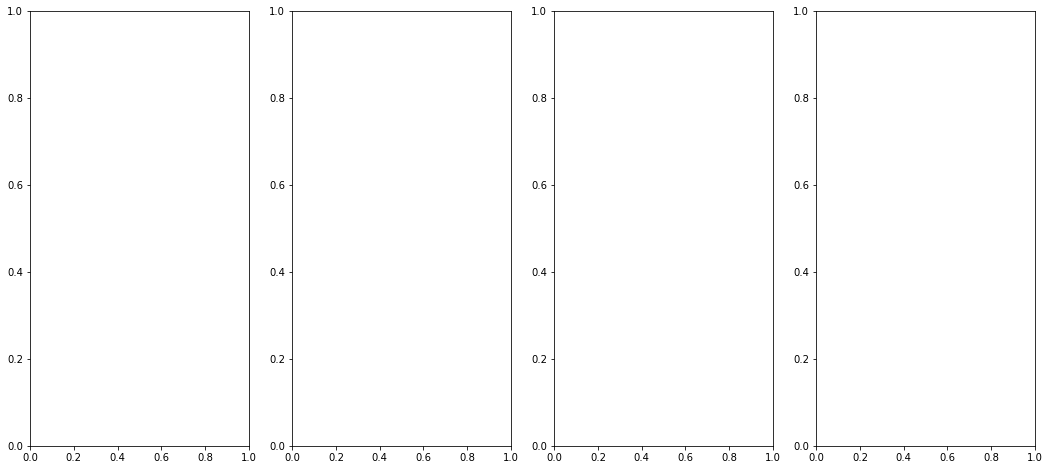

In [11]:
def iter_by_two(input1,input2,input3):
    # inputs are variable names 
    # it will give 8 combinations 
    out = []
    for comb in list(product(input1,input2,input3)):
        a,b,c = comb
        out.append([a,b,c])
    return out 

studies = iter_by_two(['Exp_up', 'Exp_down'],['Rho_up', 'Rho_down'],['Hyper_m6A', 'Hypo_m6A'])
studies = [[s[0].replace('Exp','Stbl'),s[0],s[1],s[2]] for s in studies]

_, top_axs = subplots(ncols=4, nrows=1, figsize=(18, 8))
_, bot_axs = subplots(ncols=4, nrows=1, figsize=(18, 8))
# cmaps = ["cool", list("rgb"), "plasma", "viridis", "Set1"]
# letters = iter(ascii_uppercase)

for std,ax in zip(studies,chain(top_axs, bot_axs)):
    data = {}
    data = dict([[a,set(eval(a))] for a in std])
    venn(data,fontsize=10,legend_loc="upper left", ax=ax)

# Final merged table

In [7]:
def make_final_table(genes):
    # load data
    exp_df = merge_exp_data()
    stbl_df = merge_stbl_data()
    data = load_data()
    
    # get intersects 
    def get_intersect_df(data,k=None,intersect_genes=genes):
        # change intersect_genes based on the biological question
        if k is not None: 
            df = data[k]
        else: 
            df = data

        out = df.iloc[[i for i, g in enumerate (df.gene_name) if g in list(intersect_genes)],]
        
        return out

    E = get_intersect_df(exp_df)
    S = get_intersect_df(stbl_df)
    M = get_intersect_df(data['hl60'],'delta_mtyl')
    T = get_intersect_df(data['hl60'],'delta_te')
    R = get_intersect_df(data['hl60'],'rho')
    G = get_intersect_df(data['hl60'],'gamma')

    out = pd.DataFrame(index=genes)

    out = pd.concat([
        out,
        # Expression
        E.reset_index().set_index('gene_name').iloc[:,range(1,13)].add_prefix('Exp.'),
        # Stability 
        S.reset_index().set_index('gene_name').iloc[:,range(1,13)].add_prefix('Stbl.'),
        # Translational Efficiency 
        T.reset_index().set_index('gene_name').iloc[:,[2,3]].add_prefix('TE.'),
        # CRISPR Screen Rho score
        R.reset_index().set_index('gene_name').iloc[:,[2,3]].add_prefix('Rho.'),
        # CRISPR Screen Gamma score
        G.reset_index().set_index('gene_name').iloc[:,[2,3]].add_prefix('Gamma.')

    ],axis=1)
    
    return out 


### Rho_down & Exp_down & Stbl_down & Hyper_m6A

In [15]:
hypothesis1 = list(set(Rho_down).intersection(Exp_down,Stbl_down,Hyper_m6A))

make_final_table(hypothesis1)

,Exp.hl60.log2FC_120h,Exp.hl60.pval_120h,Exp.kg1.log2FC,Exp.kg1.pval,Exp.molm14.log2FC,Exp.molm14.pval,Exp.ociaml2.log2FC,Exp.ociaml2.pval,Exp.ociaml3.log2FC,Exp.ociaml3.pval,...,Stbl.ociaml3.logFC,Stbl.ociaml3.pval,Stbl.thp1.logFC,Stbl.thp1.pval,TE.Estimate_treatmentDRUG,TE.fdr_Pr...z.._treatmentDRUG,Rho.Mann-Whitney p-value,Rho.rho score,Gamma.Mann-Whitney p-value,Gamma.gamma score
PTEN,-0.043190,0.243896,-0.374354,0.004538,0.026536,0.887824,-0.014289,0.916647,0.174083,0.436130,...,0.607390,0.000967,0.026634,0.847063,0.147879,0.908178,0.000329498,-0.329989,0.000856987,0.0691307
CLIP1,-1.192878,0.000525,0.057066,0.716293,-0.456842,0.007228,-0.127641,0.455313,-0.141038,0.539195,...,-0.221320,0.080116,-0.201255,0.044708,NaN,NaN,0.0486743,-0.0726973,0.219271,-0.0194893
BCL2,-0.349876,0.348927,-0.175130,0.308083,-0.858020,0.000052,-0.665481,0.001688,-0.442377,0.031822,...,0.189016,0.105029,-0.044006,0.625224,-0.083966,0.959806,0.000775687,-0.410753,0.000172822,-0.145611
P4HB,-0.002595,0.767401,0.530324,0.000548,0.346501,0.021534,0.006299,0.957059,-0.236551,0.239306,...,-0.275514,0.028601,-0.048505,0.702982,0.129663,0.151339,0.0113637,-0.103476,0.404723,0.0134646


### Rho_down & Exp_down & Hyper_m6A

In [16]:
hypothesis2 = list(set(Rho_down).intersection(Exp_down,Hyper_m6A))

make_final_table(hypothesis2)

,Exp.hl60.log2FC_120h,Exp.hl60.pval_120h,Exp.kg1.log2FC,Exp.kg1.pval,Exp.molm14.log2FC,Exp.molm14.pval,Exp.ociaml2.log2FC,Exp.ociaml2.pval,Exp.ociaml3.log2FC,Exp.ociaml3.pval,...,Stbl.ociaml3.logFC,Stbl.ociaml3.pval,Stbl.thp1.logFC,Stbl.thp1.pval,TE.Estimate_treatmentDRUG,TE.fdr_Pr...z.._treatmentDRUG,Rho.Mann-Whitney p-value,Rho.rho score,Gamma.Mann-Whitney p-value,Gamma.gamma score
TRPM2,-0.037420,6.970524e-01,-0.501264,0.026138,-0.518698,1.232178e-02,-0.198370,0.176066,-0.590406,0.007816,...,-0.064611,0.526100,-0.225486,0.127369,0.243977,0.563951,0.028282,-0.0966818,0.00215321,-0.0556825
P4HB,-0.002595,7.674008e-01,0.530324,0.000548,0.346501,2.153388e-02,0.006299,0.957059,-0.236551,0.239306,...,-0.275514,0.028601,-0.048505,0.702982,0.129663,0.151339,0.0113637,-0.103476,0.404723,0.0134646
MYBBP1A,0.924299,1.221487e-15,-0.158911,0.502410,-0.498212,3.964706e-02,-0.240638,0.270469,-0.472876,0.012616,...,NaN,NaN,NaN,NaN,0.127798,0.873925,0.00989941,-0.12811,0.000181093,-0.367285
PTEN,-0.043190,2.438965e-01,-0.374354,0.004538,0.026536,8.878241e-01,-0.014289,0.916647,0.174083,0.436130,...,0.607390,0.000967,0.026634,0.847063,0.147879,0.908178,0.000329498,-0.329989,0.000856987,0.0691307
WDR90,1.480258,7.650223e-04,-0.012243,0.955877,-0.952794,9.289137e-04,-0.147226,0.565691,-0.268917,0.370784,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0239595,-0.0810468,0.0519315,0.0290127
PRDM15,-0.052669,2.828007e-01,-0.769876,0.003200,0.146448,5.961705e-01,-0.228723,0.491339,-1.425863,0.000039,...,NaN,NaN,NaN,NaN,0.072590,0.971368,0.00211632,-0.154041,0.000412171,-0.079837
FAT1,-0.054781,4.708737e-01,0.659045,0.087709,1.576543,4.307025e-04,-1.404775,0.069964,0.824195,0.004850,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0121556,-0.171184,0.325553,-0.0168907
GNE,-0.015456,9.264026e-03,0.600234,0.003023,0.408968,1.801776e-01,-0.021052,0.910227,-0.294017,0.182107,...,NaN,NaN,NaN,NaN,0.514365,0.550430,0.00347083,-0.127746,0.0604554,0.0320847
MACF1,-0.155320,7.308562e-01,0.028899,0.873131,-0.394813,1.624712e-02,-0.138717,0.448829,-0.349442,0.045227,...,-0.193142,0.109224,-0.201676,0.053022,NaN,NaN,0.0314761,-0.0905704,0.0800886,0.0647478
RGS19,-0.016131,4.650503e-02,-1.063766,0.003845,-0.308340,2.796694e-01,0.350560,0.243924,0.910578,0.028696,...,NaN,NaN,NaN,NaN,0.107834,0.927907,0.00644121,-0.222487,0.11254,0.027393


### Rho_up & Exp_down & Stbl_down & Hyper_m6A

In [17]:
hypothesis3 = list(set(Rho_up).intersection(Exp_down,Stbl_down,Hyper_m6A))

make_final_table(hypothesis3)

,Exp.hl60.log2FC_120h,Exp.hl60.pval_120h,Exp.kg1.log2FC,Exp.kg1.pval,Exp.molm14.log2FC,Exp.molm14.pval,Exp.ociaml2.log2FC,Exp.ociaml2.pval,Exp.ociaml3.log2FC,Exp.ociaml3.pval,...,Stbl.ociaml3.logFC,Stbl.ociaml3.pval,Stbl.thp1.logFC,Stbl.thp1.pval,TE.Estimate_treatmentDRUG,TE.fdr_Pr...z.._treatmentDRUG,Rho.Mann-Whitney p-value,Rho.rho score,Gamma.Mann-Whitney p-value,Gamma.gamma score
gene_name,,,,,,,,,,,,,,,,,,,,,
SLC38A2,0.093455,0.006681,0.071612,0.611155,-1.191847,5.722526e-17,-0.190977,0.17824,-0.447406,0.049998,...,-0.317507,0.015238,0.05032,0.625428,0.259593,0.442778,0.000507845,0.147765,0.00107525,-0.0523004


### Rho_up & Exp_down & Hyper_m6A

In [18]:
hypothesis4 = list(set(Rho_up).intersection(Exp_down,Hyper_m6A))

make_final_table(hypothesis4)

,Exp.hl60.log2FC_120h,Exp.hl60.pval_120h,Exp.kg1.log2FC,Exp.kg1.pval,Exp.molm14.log2FC,Exp.molm14.pval,Exp.ociaml2.log2FC,Exp.ociaml2.pval,Exp.ociaml3.log2FC,Exp.ociaml3.pval,...,Stbl.ociaml3.logFC,Stbl.ociaml3.pval,Stbl.thp1.logFC,Stbl.thp1.pval,TE.Estimate_treatmentDRUG,TE.fdr_Pr...z.._treatmentDRUG,Rho.Mann-Whitney p-value,Rho.rho score,Gamma.Mann-Whitney p-value,Gamma.gamma score
UHRF1,0.531555,1.758350e-05,-0.203560,0.203841,-0.341414,1.792914e-02,-0.206180,0.119950,-0.195101,0.291769,...,-0.204375,0.175788,0.059026,0.669261,NaN,NaN,0.0427943,0.12052,0.00961853,-0.317194
GPT2,1.524728,4.309582e-12,-0.336287,0.096915,-1.770456,2.738655e-20,0.132678,0.713788,-0.644829,0.010065,...,NaN,NaN,NaN,NaN,0.354041,0.644297,0.0473591,0.125704,0.154324,-0.108191
ASCC3,0.745191,6.915685e-03,-0.294442,0.041738,-0.060169,7.057223e-01,-0.075511,0.546076,0.038017,0.855646,...,0.304848,0.029294,0.264479,0.054867,-0.091706,0.905505,0.0351948,0.196043,0.000294497,-0.150862
SF3B5,1.203213,4.116974e-03,-0.435174,0.044762,0.057846,8.042197e-01,-0.082510,0.725900,-0.290105,0.434542,...,NaN,NaN,NaN,NaN,0.103536,0.921463,0.0325592,0.229272,0.0141978,-0.151714
NOL10,0.703616,8.709135e-05,0.064696,0.646424,-0.504675,1.469999e-03,-0.152826,0.323571,-0.304531,0.187574,...,0.114226,0.516558,0.131014,0.242626,-0.008543,0.992870,0.0451808,0.0648528,0.0209127,-0.14716
TET2,-0.527016,2.863628e-05,0.406066,0.047659,0.755745,1.383146e-02,0.273744,0.218360,0.338139,0.343063,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0446586,0.157896,0.849894,0.0208175
SLC38A5,4.054743,1.662798e-24,-0.025667,0.882894,-0.616488,6.400979e-02,-0.431919,0.132093,-1.162242,0.000057,...,NaN,NaN,NaN,NaN,0.066110,0.945820,0.00292038,0.102464,0.0090272,-0.0542386
HPS4,0.909969,2.881971e-04,-0.397124,0.025435,-0.309156,1.722613e-01,0.080886,0.721161,-0.061893,0.834283,...,NaN,NaN,NaN,NaN,0.028135,0.988401,0.027618,0.148254,0.355666,0.0349674
EP400,0.056058,7.332842e-01,0.035975,0.778765,-0.356828,1.350930e-02,-0.092179,0.496772,-0.467815,0.010213,...,NaN,NaN,NaN,NaN,0.129425,0.770643,0.0043054,0.384251,0.00253747,-0.206212
ACSF3,-0.272758,2.344411e-01,-0.086144,0.664926,-0.587529,2.824242e-02,-0.826967,0.012466,-0.638348,0.020681,...,NaN,NaN,NaN,NaN,0.080759,0.970239,0.0160557,0.114455,0.416631,0.000913454


In [ ]:
# final.to_csv('combined.txt', sep='\t')

In [ ]:
# # https://stackoverflow.com/questions/3852780/python-intersection-of-multiple-lists
# def intersect(*d):
#     sets = iter(map(set, d))
#     result = sets.next()
#     for s in sets:
#         result = result.intersection(s)
#     return result

In [ ]:
# %reload_ext rpy2.ipython

In [ ]:
# %%R 
# suppressMessages(suppressWarnings(library (UpSetR)))
# suppressMessages(suppressWarnings(library (gplots)))
# suppressMessages(suppressWarnings(library (patchwork)))

In [ ]:
# %%R 
# intersect <- function(Vecs){
#     intersection <- Reduce(intersect,Vecs)
#     SET = upset(fromList(Vecs), order.by = "freq")
#     print (SET)
#     return(intersection)
# }

In [ ]:
# %%R -i Rho_down,Exp_down,Stbl_down,Hyper_m6A -o ouput1

# Vecs <- list(
#     delta_mtyl = unlist(M_genes),
#     delta_te = unlist(T_genes),
#     rho = unlist(R_genes),
#     delta_stbl = unlist(S_genes),
#     delta_exp = unlist(E_genes)
# )

# A_genes = intersect(Vecs)